In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

Using TensorFlow backend.


In [0]:
# Training parameters
batch_size = 128 # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
depth = n * 6 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [4]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [6]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# Learning Rate Schedule
def lr_schedule(epoch):
    lr = 1e-3

    if epoch > 40:
        lr *= 1e-3
    elif epoch > 30:
        lr *= 1e-2
    elif epoch > 25:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
# 2D Convolution-Batch Normalization-Activation stack builder
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
  
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
model = resnet_v1(input_shape=input_shape, depth=depth)


In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

Learning rate:  0.001




In [18]:
model.summary()
print(model_type)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 32, 32, 16)   64          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 32, 32, 16)   0           batch_normalization_7[0][0]      
____________________________________________________________________________________________

In [0]:
# Prepare model model saving directory.
save_dir = './content/cifar10model' + 'saved_models'
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = save_dir + model_name

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [21]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

Using real-time data augmentation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
Learning rate:  0.001
391/391 [==============================] - 38s 97ms/step - loss: 1.6795 - acc: 0.4509 - val_loss: 5.9961 - val_acc: 0.1025

Epoch 00001: val_acc improved from -inf to 0.10250, saving model to ./content/cifar10modelsaved_modelscifar10_ResNet20v1_model.001.h5
Epoch 2/50
Learning rate:  0.001
391/391 [==============================] - 29s 74ms/step - loss: 1.2673 - acc: 0.6013 - val_loss: 10.6414 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.10250
Epoch 3/50
Learning rate:  0.001
391/391 [==============================] - 29s 75ms/step - loss: 1.0784 - acc: 0.6714 - val_loss: 3.9656 - val_acc: 0.1481

Epoch 00003: val_acc improved from 0.10250 to 0.14810, saving model to ./content/cifar10modelsaved_modelscifar10_ResNet20v1_model.003.h5
Epoch 4/50
Learning rate:  0.001
391/391 [==============================] - 

In [22]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 153us/step
Test loss: 0.5085158107757568
Test accuracy: 0.8808


#  GradCam Results

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
from skimage import io
from google.colab.patches import cv2_imshow

In [0]:
imagelist1=[
 "https://upload.wikimedia.org/wikipedia/commons/3/37/African_Bush_Elephant.jpg",
 "https://img.etimg.com/thumb/width-640,height-480,imgsize-80208,resizemode-1,msid-59519782/mercedes-benz-india-climbs-up-the-ladder-in-overall-car-market-as-well.jpg",
 "https://thumbs.dreamstime.com/b/flower-535300.jpg",
 "https://static.independent.co.uk/s3fs-public/thumbnails/image/2019/07/28/14/po-britannia.jpg",
 "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fc1.staticflickr.com%2F1%2F418%2F18262633594_3563a9c5a2_b.jpg&f=1&nofb=1",
 "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKXrUaxWbbl8Q7iFatqkeT1DSOZeRhu3Aqwvb6rqbGnux7I6p_&s",
 "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRKt5IkPa-VVs7pzU7IvziYdvX0eN6-qpcMyCHCIn5OMLKtFrOj&s",
 "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.2mggqeJ4NZV5yiwdvcq5YwHaFj%26pid%3DApi&f=1",
 "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse3.mm.bing.net%2Fth%3Fid%3DOIP.txqct3wOYRHYm77YCgcXPQHaEO%26pid%3DApi&f=1",
 "https://www.petmd.com/sites/default/files/frog-care-101.jpg"]

In [0]:
def gradcam(imagelist,models):

  for img in imagelist:

      #4. Rescale image to 224x224x3 (VGG's expectation, why?)
      #5. Use expand_dims to convert image to a batch of size 1
      #6. Preprocesing normalizes our input image by subtracting mean RGB values
      print(img)
      img = io.imread(img)
      img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      
      x = preprocess_input(x)
      x /= 255


      #1. We get the predictions for the image
      #2. We take the topmost class index
      #3. Take output from the final convolutional layer
      preds = model.predict(x)
      class_idx = np.argmax(preds[0])
      print(class_idx)
      class_output = model.output[:, class_idx]
      last_conv_layer = model.get_layer("conv2d_27")


      #1. Compute the gradient of the class output value with respect to the feature map
      #2. Pool the gradients over all the axies leaving out the channel dimension
      #3. Weigh the output feature map with the computed gradient values
      grads = K.gradients(class_output, last_conv_layer.output)[0]
      print(grads.shape)
      pooled_grads = K.mean(grads, axis=(0, 1, 2))
      print(pooled_grads.shape)
      iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

      pooled_grads_value, conv_layer_output_value = iterate([x])

      for i in range(64):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]


      
      #1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
      #2. Normalize the heat map to make the values between 0 and 1
      heatmap = np.mean(conv_layer_output_value, axis = -1)
      print(conv_layer_output_value.shape)
      print(heatmap.shape)
      heatmap = np.maximum(heatmap, 0)
      heatmap /= np.max(heatmap)


      #Show the results
      img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
      heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
      heatmap = np.uint8(255 * heatmap)
      heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
      superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.9, 0)
      from google.colab.patches import cv2_imshow
      cv2_imshow(img)
      cv2_imshow(superimposed_img)

https://upload.wikimedia.org/wikipedia/commons/3/37/African_Bush_Elephant.jpg
1
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


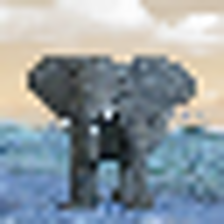

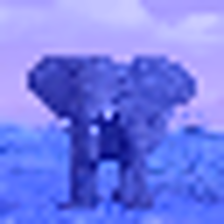

https://img.etimg.com/thumb/width-640,height-480,imgsize-80208,resizemode-1,msid-59519782/mercedes-benz-india-climbs-up-the-ladder-in-overall-car-market-as-well.jpg
1
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


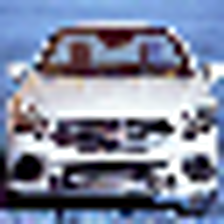

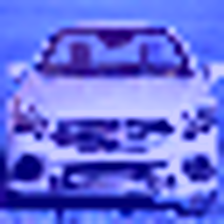

https://thumbs.dreamstime.com/b/flower-535300.jpg
1
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


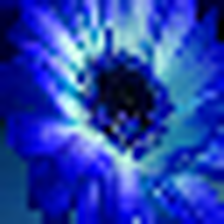

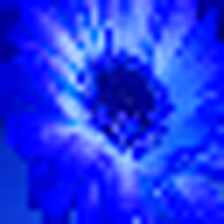

https://static.independent.co.uk/s3fs-public/thumbnails/image/2019/07/28/14/po-britannia.jpg
1
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


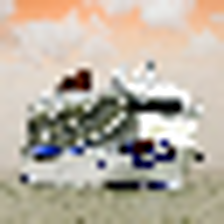

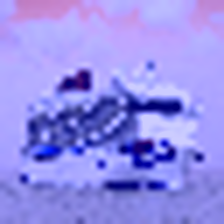

https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fc1.staticflickr.com%2F1%2F418%2F18262633594_3563a9c5a2_b.jpg&f=1&nofb=1
1
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


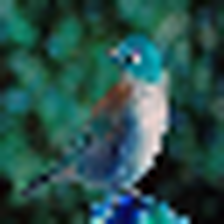

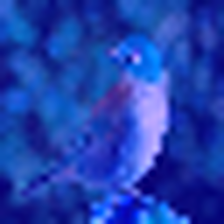

https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKXrUaxWbbl8Q7iFatqkeT1DSOZeRhu3Aqwvb6rqbGnux7I6p_&s
1
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


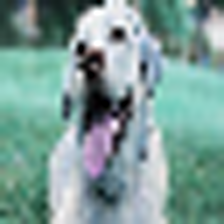

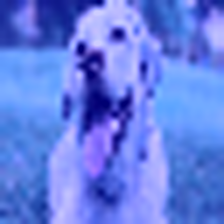

https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRKt5IkPa-VVs7pzU7IvziYdvX0eN6-qpcMyCHCIn5OMLKtFrOj&s
1
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


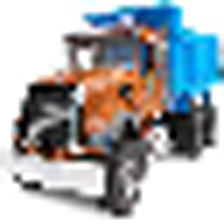

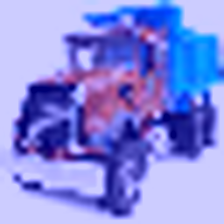

https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.2mggqeJ4NZV5yiwdvcq5YwHaFj%26pid%3DApi&f=1
1
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


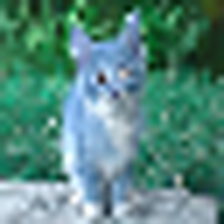

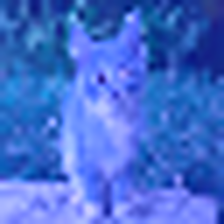

https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse3.mm.bing.net%2Fth%3Fid%3DOIP.txqct3wOYRHYm77YCgcXPQHaEO%26pid%3DApi&f=1
1
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


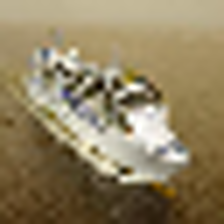

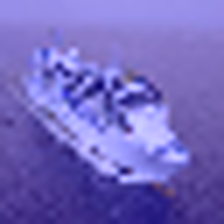

https://www.petmd.com/sites/default/files/frog-care-101.jpg
1
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


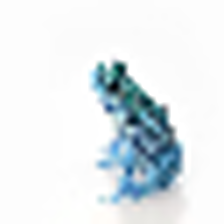

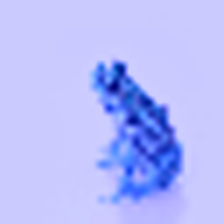

In [77]:
gradcam(imagelist=imagelist1,models=model)